# Multi-Scale Pyramid Comparison of SVG Shapes

This notebook demonstrates generating SVG shapes and comparing them using various multi-scale approaches:
- **Laplacian Pyramid**: High-frequency detail preservation
- **Gaussian Pyramid**: Multi-scale structure analysis  
- **L2 Distance**: Pixel-wise comparison
- **DreamSim**: Perceptual similarity


In [1]:
%load_ext autoreload
%autoreload 2

In [5]:
import sys
import os
import torch
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

# Add parent directory to path to import local modules
sys.path.append('..')

# Set DreamSim cache directory to use the project's models directory
os.environ['DREAMSIM_CACHE_DIR'] = '../models'

from prefixrl.reward.image.laplacian import (
    compare_images_by_laplacian,
    laplacian_pyramid,
)
from prefixrl.reward.image.gaussian import (
    compare_images_by_gaussian,
    gaussian_pyramid,
)
from prefixrl.reward.image.l2 import compare_images_by_l2
from prefixrl.reward.image.dreamsim import compare_images_by_dreamsim
from prefixrl.reward.image.util import pil_to_tensor
from prefixrl.reward.svg.cairosvg import rasterize_svg
from prefixrl.reward.svg.shapes import make_circle, make_line, make_rectangle

# if we only care about the image, we can use this shortcut
def rasterize(svg: str):
    img, _, _ = rasterize_svg(svg)
    return img

print(f"Using python '{sys.version}'")
print(f"Using torch '{torch.__version__}'")


Using python '3.12.10 (main, Apr  9 2025, 03:49:38) [Clang 20.1.0 ]'
Using torch '2.7.0'


In [6]:
# prewarm comparator so it doesn't spew later
_im = rasterize(make_circle(r=150, fill="white", stroke="grey", stroke_width=10, background="white"))
_ = compare_images_by_dreamsim(_im, _im)

Generate charts for comparing different metrics with SVGs along a single parameter axis.

/var/folders/5r/np8nyb993_z6v7bj_5910qn80000gn/T/ipykernel_32182/279581742.py:110: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


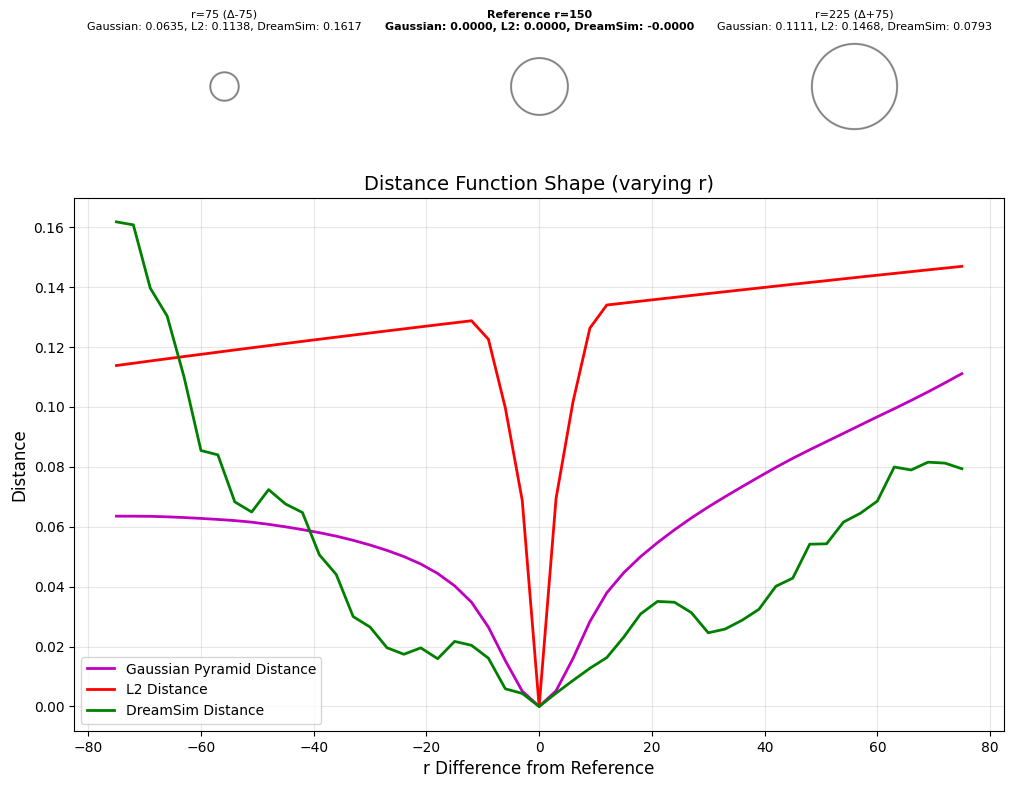

In [ ]:
from matplotlib.gridspec import GridSpec
from typing import Callable

# We need to scale up the Gaussian distance to make it more visible, because we're weighting low-frequency structure more heavily
g_scale = 50.0

# Distance metrics: (name, function, color)
distance_metrics = [
    # ("Laplacian Pyramid Distance", compare_images_by_laplacian, 'b-'),
    (
        "Gaussian Pyramid Distance",
        lambda img, img_ref: compare_images_by_gaussian(img, img_ref)
        * g_scale,
        "m-",
    ),
    ("L2 Distance", compare_images_by_l2, "r-"),
    ("DreamSim Distance", compare_images_by_dreamsim, "g-"),
]


def compare_svg_parameter_distances(
    shape_func: Callable[[float], str],
    param_values: list[float],
    reference_value: float,
    param_name: str,
    example_values=None,
    figsize=(12, 9),
) -> None:
    """
    Compare Laplacian pyramid, Gaussian pyramid, L2, and DreamSim distances for different parameter values of an SVG shape.
    
    Args:
        shape_func: Function that takes a parameter value and returns SVG string
        param_values: List of parameter values to test
        reference_value: Reference parameter value for comparison
        param_name: Name of the parameter being varied (for labels)
        example_values: Optional list of 3 values to show as examples (defaults to [min, ref, max])
        figsize: Figure size tuple
    
    """
    
    def calculate_all_distances(img, img_ref):
        return tuple(fn(img, img_ref) for name, fn, color in distance_metrics)

    # Ensure reference value is in the test values
    if reference_value not in param_values:
        param_values = list(param_values) + [reference_value]
        param_values.sort()
    
    # Create reference image
    img_ref = rasterize(shape_func(reference_value))
    
    # Compute distances for all parameter values
    all_distances = [[] for _ in distance_metrics]
    
    for param_val in param_values:
        svg = shape_func(param_val)
        img = rasterize(svg)
        
        distances = calculate_all_distances(img, img_ref)
        for i, dist in enumerate(distances):
            all_distances[i].append(dist)
    
    # Choose example values for display
    if example_values is None:
        example_values = [min(param_values), reference_value, max(param_values)]
    
    # Generate example images and distances
    example_images = []
    example_distances = [[] for _ in distance_metrics]
    
    for val in example_values:
        svg = shape_func(val)
        img = rasterize(svg)
        example_images.append(img)
        
        distances = calculate_all_distances(img, img_ref)
        
        for i, dist in enumerate(distances):
            example_distances[i].append(dist)
    

    
    # Create visualization
    fig = plt.figure(figsize=figsize)
    gs = GridSpec(2, 3, figure=fig, height_ratios=[0.4, 2.2], hspace=0.2, wspace=0.05)
    
    # Top row: 3 example shapes
    for i, (val, img) in enumerate(zip(example_values, example_images)):
        ax = fig.add_subplot(gs[0, i])
        ax.imshow(img)
        param_diff = val - reference_value
        
        # Get distances for this example
        distances_str = ", ".join([f"{name.split()[0]}: {example_distances[j][i]:.4f}" 
                                  for j, (name, _, _) in enumerate(distance_metrics)])
        
        if val == reference_value:
            ax.set_title(f"Reference {param_name}={val}\n{distances_str}", fontweight='bold', fontsize=8)
        else:
            ax.set_title(f"{param_name}={val} (Δ{param_diff:+})\n{distances_str}", fontsize=8)
        ax.axis('off')
    
    # Bottom: Main comparison graph
    ax_main = fig.add_subplot(gs[1, :])
    param_diff = [val - reference_value for val in param_values]
    
    # Plot all distance metrics using arrays
    for i, (distances, (name, _, color)) in enumerate(zip(all_distances, distance_metrics)):
        ax_main.plot(param_diff, distances, color, linewidth=2, label=name)
    
    ax_main.set_xlabel(f"{param_name} Difference from Reference", fontsize=12)
    ax_main.set_ylabel("Distance", fontsize=12)
    ax_main.set_title(f"Distance Function Shape (varying {param_name})", fontsize=14)
    ax_main.grid(True, alpha=0.3)
    ax_main.legend()
    
    plt.tight_layout()
    plt.show()

# ------------------------------------------------------------------------------------------------

compare_svg_parameter_distances(
    shape_func=lambda r: make_circle(r=r, fill="white", stroke="grey", stroke_width=10, background="white"),
    param_values=range(75, 226, 3),
    reference_value=150,
    param_name="r",
    example_values=[75, 150, 225],
)


### Individual shape tests

/var/folders/5r/np8nyb993_z6v7bj_5910qn80000gn/T/ipykernel_32182/279581742.py:110: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


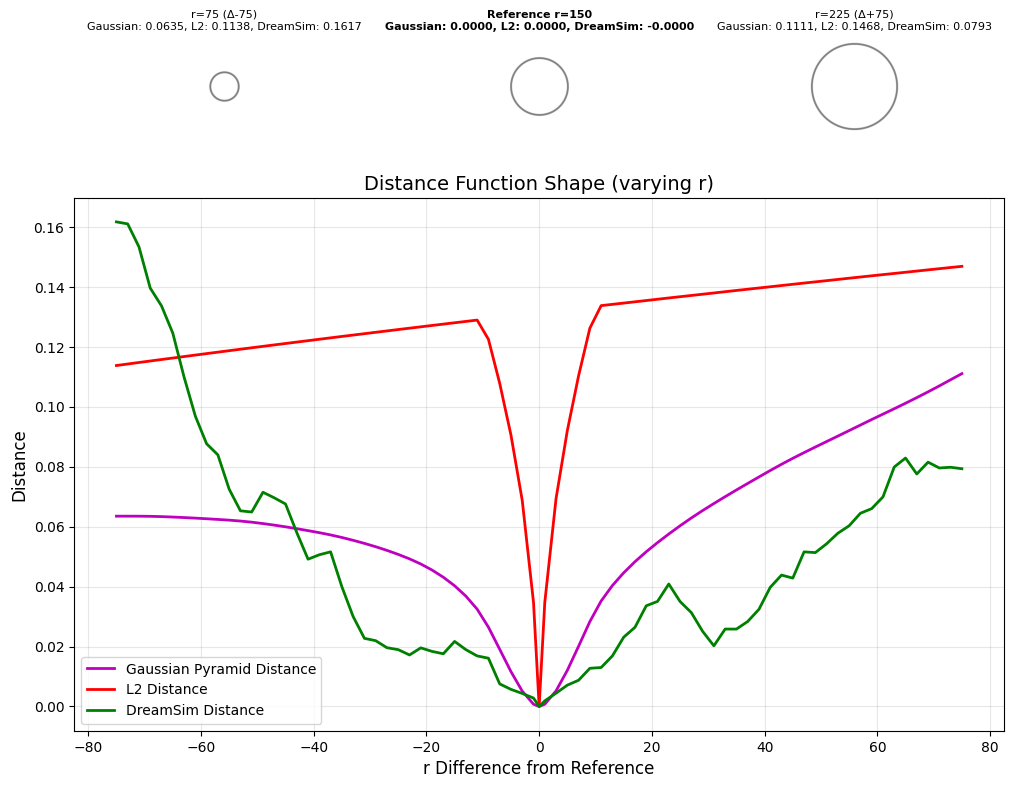

In [26]:
compare_svg_parameter_distances(
    shape_func=lambda r: make_circle(r=r, fill="white", stroke="grey", stroke_width=10, background="white"),
    param_values=np.arange(75, 226, 2),
    reference_value=150,
    param_name="r",
    example_values=[75, 150, 225],
)

/var/folders/5r/np8nyb993_z6v7bj_5910qn80000gn/T/ipykernel_32182/279581742.py:110: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


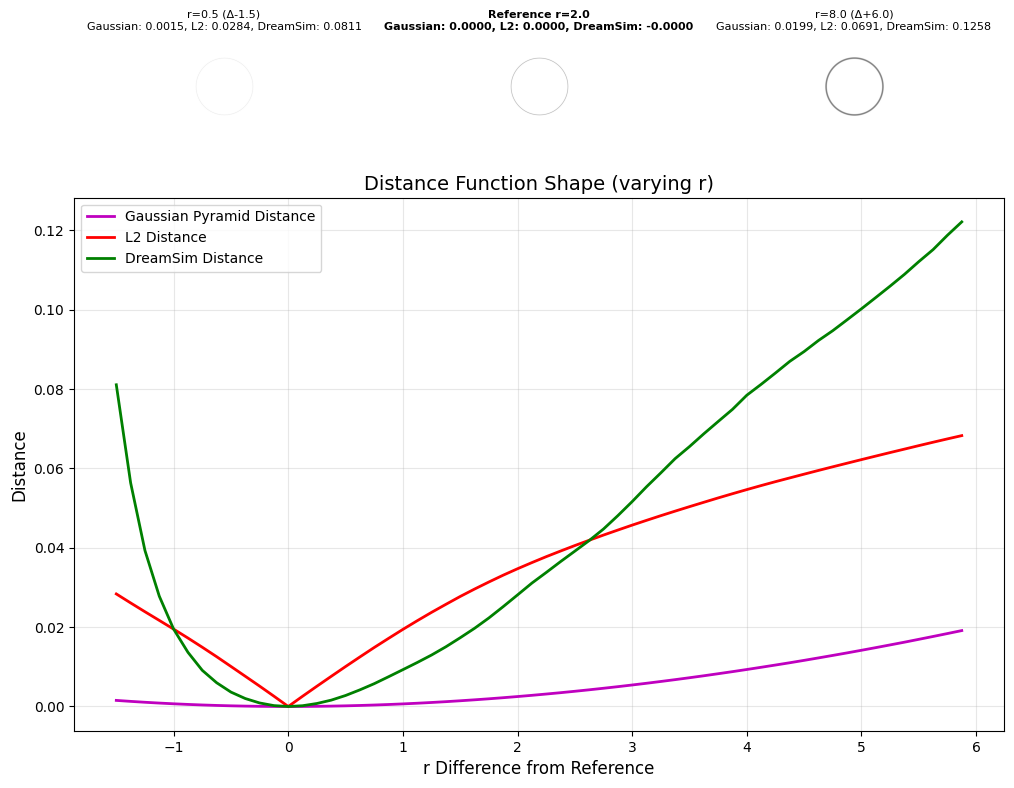

In [27]:
compare_svg_parameter_distances(
    shape_func=lambda w: make_circle(
        r=150, fill="white", stroke="grey", stroke_width=w, background="white"
    ),
    param_values=np.arange(0.5, 8.0, 0.125),
    reference_value=2.0,
    param_name="r",
    example_values=[0.5, 2.0, 8.0],
)


/var/folders/5r/np8nyb993_z6v7bj_5910qn80000gn/T/ipykernel_32182/279581742.py:110: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


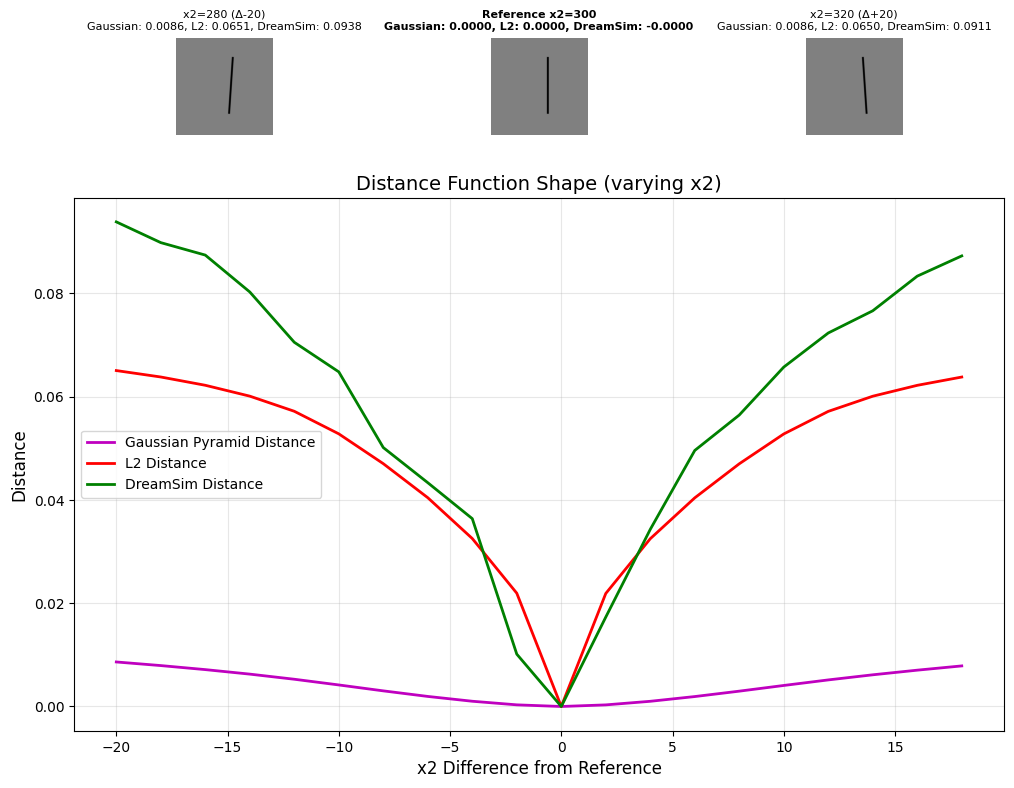

In [29]:
compare_svg_parameter_distances(
    shape_func=lambda x: make_line(x1=300, y1=100, x2=x, y2=400, stroke_width=10, background="gray"),
    param_values=range(300-20, 300+20, 2),
    reference_value=300,
    param_name="x2",
    example_values=[300-20, 300, 300+20],
)

/var/folders/5r/np8nyb993_z6v7bj_5910qn80000gn/T/ipykernel_1701/558484028.py:118: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


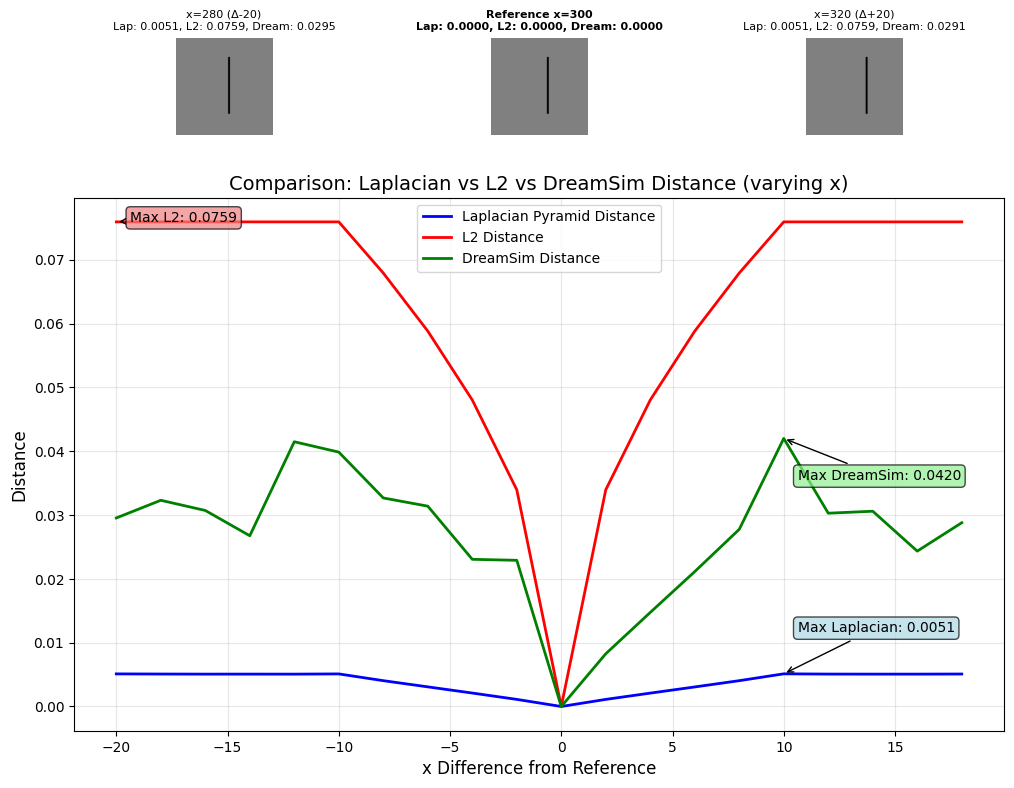

In [72]:
compare_svg_parameter_distances(
    shape_func=lambda x: make_line(
        x1=x, y1=100, x2=x, y2=400, stroke_width=10, background="gray"
    ),
    param_values=range(300 - 20, 300 + 20, 2),
    reference_value=300,
    param_name="x",
    example_values=[300 - 20, 300, 300 + 20],
)


/var/folders/5r/np8nyb993_z6v7bj_5910qn80000gn/T/ipykernel_1701/558484028.py:118: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


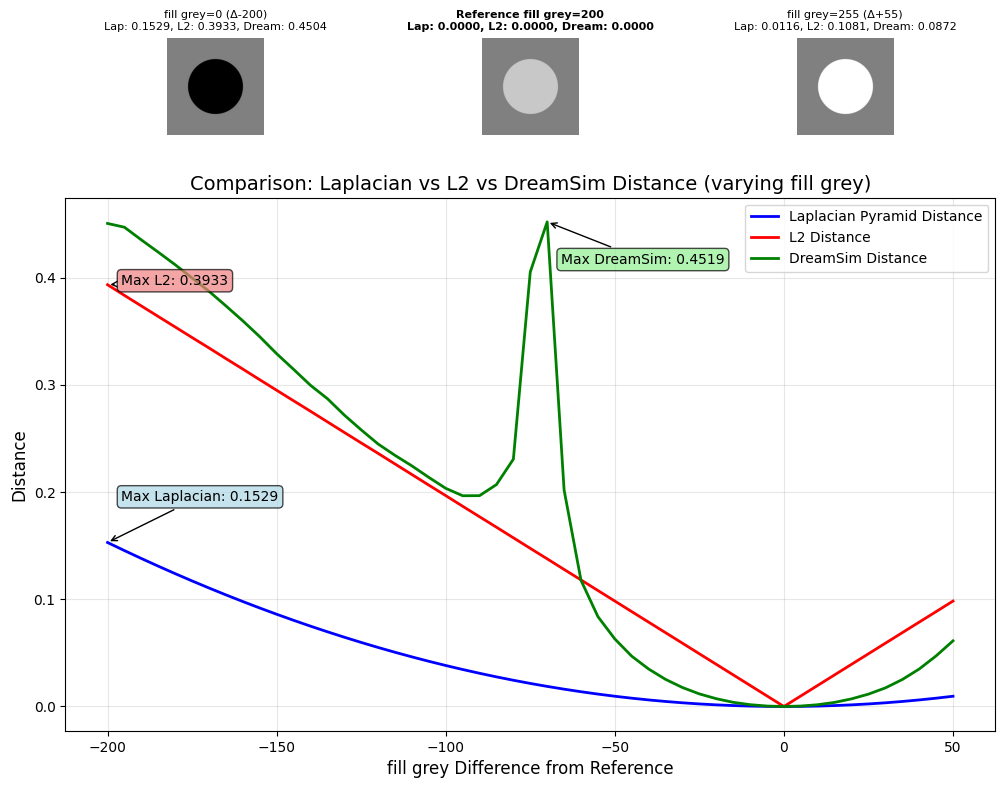

In [80]:
compare_svg_parameter_distances(
    shape_func=lambda bg: make_circle(
        r=150,
        fill=f"#{int(bg):02x}{int(bg):02x}{int(bg):02x}",
        stroke="grey",
        stroke_width=10,
        background="gray",
    ),
    param_values=np.arange(0, 255, 5),
    reference_value=200,
    param_name="fill grey",
    example_values=[0, 200, 255],
)


There is a spike in the DreamSim distance at 128, where the image becomes a solid color. This is actually desired behavior, as humans would perceive the image as more dissimilar to the reference image.

## Multi-Scale Pyramid Visualizations

Visualize the hierarchical structure of both Laplacian and Gaussian pyramids, showing how information flows from fine to coarse scales.

### Laplacian Pyramid
Stores high-frequency details (edges, textures) at each scale.


### Gaussian Pyramid
Stores progressively downsampled/blurred versions of the image at each scale.


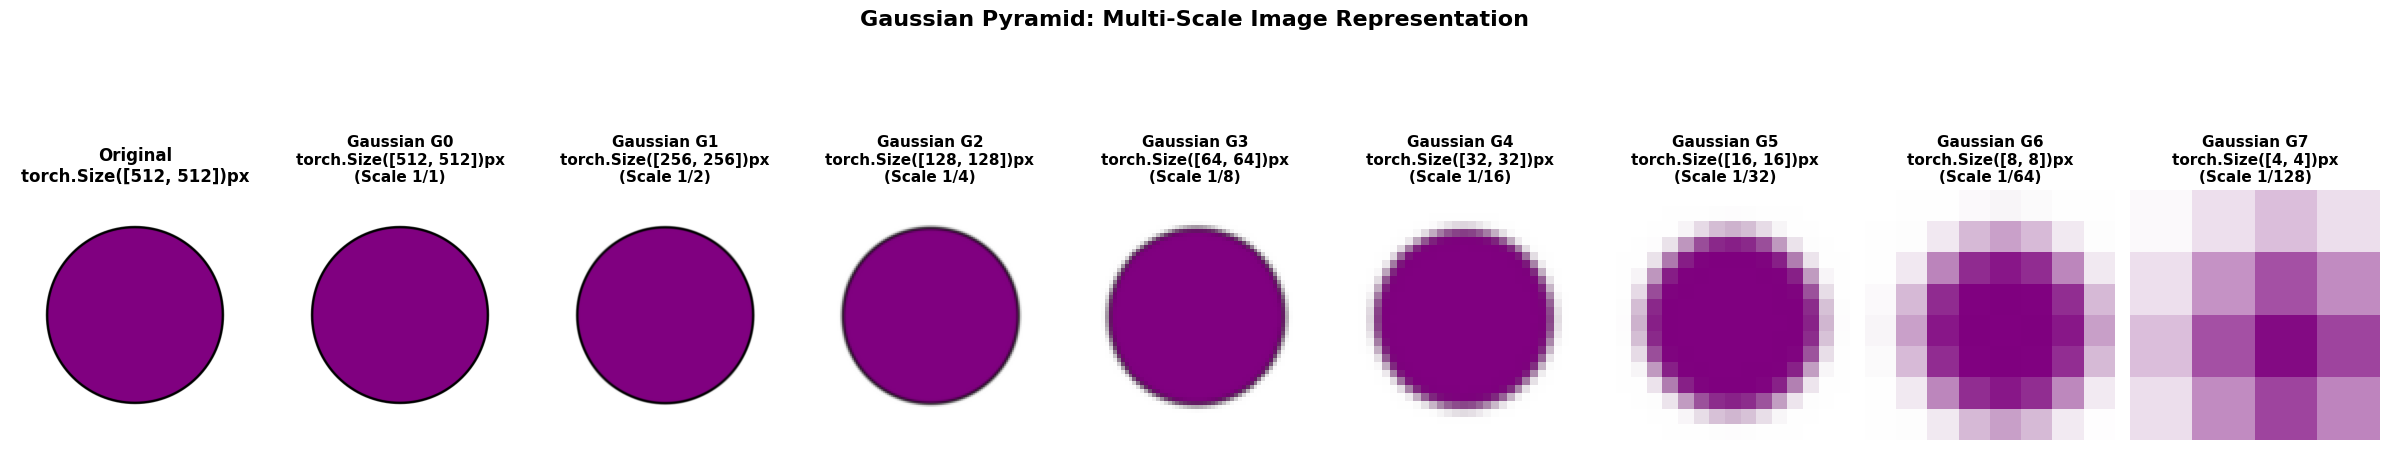

Gaussian Pyramid Level Statistics:
--------------------------------------------------
Level 0 (Gaussian G0):
  Shape: torch.Size([1, 3, 512, 512])
  Range: [0.0000, 1.0000]
  Mean: 0.7272, Std: 0.3669

Level 1 (Gaussian G1):
  Shape: torch.Size([1, 3, 256, 256])
  Range: [0.0000, 1.0000]
  Mean: 0.7272, Std: 0.3639

Level 2 (Gaussian G2):
  Shape: torch.Size([1, 3, 128, 128])
  Range: [0.0000, 1.0000]
  Mean: 0.7272, Std: 0.3594

Level 3 (Gaussian G3):
  Shape: torch.Size([1, 3, 64, 64])
  Range: [0.0000, 1.0000]
  Mean: 0.7272, Std: 0.3530

Level 4 (Gaussian G4):
  Shape: torch.Size([1, 3, 32, 32])
  Range: [0.0000, 1.0000]
  Mean: 0.7272, Std: 0.3433

Level 5 (Gaussian G5):
  Shape: torch.Size([1, 3, 16, 16])
  Range: [0.0000, 1.0000]
  Mean: 0.7272, Std: 0.3255

Level 6 (Gaussian G6):
  Shape: torch.Size([1, 3, 8, 8])
  Range: [0.0000, 1.0000]
  Mean: 0.7263, Std: 0.2885

Level 7 (Gaussian G7):
  Shape: torch.Size([1, 3, 4, 4])
  Range: [0.0405, 0.9880]
  Mean: 0.7166, Std: 0.2165



In [28]:
def visualize_gaussian_pyramid_horizontal(img, levels=4, figsize=(18, 6), padding_mode="reflect"):
    """
    Visualize the Gaussian pyramid in a simple horizontal row layout.
    All images are displayed at the same size for easy comparison.
    
    Args:
        img: PIL Image or torch tensor
        levels: Number of pyramid levels
        figsize: Figure size tuple
        padding_mode: Padding mode for convolutions ("zeros", "reflect", "replicate", "circular")
    """
    # Convert to tensor if needed
    if isinstance(img, Image.Image):
        img_tensor = pil_to_tensor(img).unsqueeze(0)
    else:
        img_tensor = img
    
    # Compute Gaussian pyramid with configurable padding
    pyramid = gaussian_pyramid(img_tensor, levels=levels, padding_mode=padding_mode)
    
    # Create horizontal subplot layout: Original + Gaussian levels
    n_plots = 1 + len(pyramid)  # Original + all pyramid levels
    fig, axes = plt.subplots(1, n_plots, figsize=figsize)
    
    # Original image
    if isinstance(img, Image.Image):
        axes[0].imshow(img)
    else:
        img_np = img_tensor.squeeze().permute(1, 2, 0).detach().cpu().numpy()
        axes[0].imshow(img_np)
    axes[0].set_title(f"Original\n{img_tensor.shape[-2:]}px", fontsize=12, fontweight='bold')
    axes[0].axis('off')
    
    for i, level in enumerate(pyramid):
        ax_idx = i + 1
        level_np = level.squeeze().permute(1, 2, 0).detach().cpu().numpy()
        
        # Display the actual Gaussian level (no normalization needed)
        axes[ax_idx].imshow(level_np)
        axes[ax_idx].set_title(f"Gaussian G{i}\n{level.shape[-2:]}px\n(Scale 1/{2**i})", 
                             fontsize=11, fontweight='bold')

        axes[ax_idx].axis('off')
    
    plt.suptitle("Gaussian Pyramid: Multi-Scale Image Representation", 
                fontsize=16, fontweight='bold')
    plt.tight_layout()
    
    return fig, pyramid

# Test the visualization with the same circle
svg = make_circle(r=180, fill="purple", stroke_width=5)
img, _, _ = rasterize_svg(svg)

# Use same number of levels as Laplacian for comparison
fig, gaussian_pyramid_data = visualize_gaussian_pyramid_horizontal(img, levels=8, figsize=(24, 6))
plt.show()

# Print pyramid statistics
print("Gaussian Pyramid Level Statistics:")
print("-" * 50)
for i, level in enumerate(gaussian_pyramid_data):
    shape = level.shape
    min_val = level.min().item()
    max_val = level.max().item()
    mean_val = level.mean().item()
    std_val = level.std().item()
    
    print(f"Level {i} (Gaussian G{i}):")
    print(f"  Shape: {shape}")
    print(f"  Range: [{min_val:.4f}, {max_val:.4f}]")
    print(f"  Mean: {mean_val:.4f}, Std: {std_val:.4f}")
    print()


### Comparison: Laplacian vs Gaussian Pyramids

Key differences:
- **Laplacian**: Stores high-frequency details (edges, textures) with mean ≈ 0
- **Gaussian**: Stores actual downsampled images, preserving overall structure


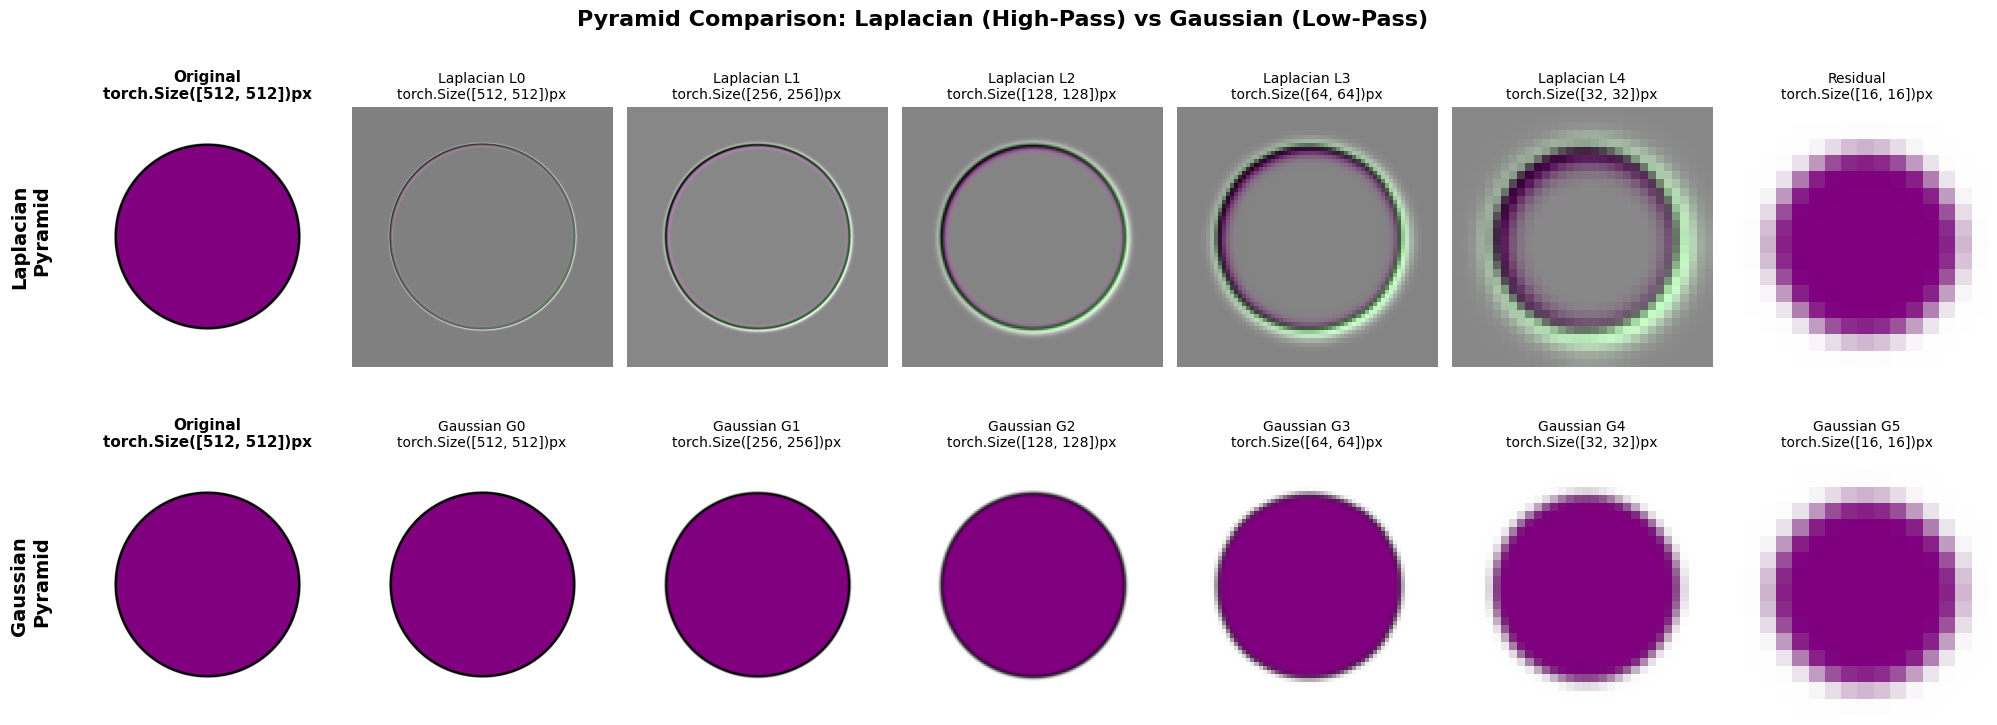

In [ ]:
def compare_pyramid_approaches(img: Image.Image, levels=4, figsize=(20, 10)):
    """
    Compare Laplacian and Gaussian pyramid approaches side by side.
    """
    # Convert to tensor if needed
    img_tensor = pil_to_tensor(img).unsqueeze(0)
    
    # Compute both pyramids
    laplacian_pyr = laplacian_pyramid(img_tensor, levels=levels)
    gaussian_pyr = gaussian_pyramid(img_tensor, levels=levels)
    
    # Create comparison layout
    fig, axes = plt.subplots(2, levels + 1, figsize=figsize)
    
    # Original image
    axes[0, 0].imshow(img)
    axes[1, 0].imshow(img)
    
    axes[0, 0].set_title(f"Original\n{img_tensor.shape[-2:]}px", fontsize=11, fontweight='bold')
    axes[1, 0].set_title(f"Original\n{img_tensor.shape[-2:]}px", fontsize=11, fontweight='bold')
    axes[0, 0].axis('off')
    axes[1, 0].axis('off')
    
    # Laplacian pyramid (top row)
    for i, level in enumerate(laplacian_pyr):
        ax_idx = i + 1
        level_np = level.squeeze().permute(1, 2, 0).detach().cpu().numpy()
        
        if i < len(laplacian_pyr) - 1:  # Laplacian levels
            level_np = (level_np - level_np.min()) / (level_np.max() - level_np.min() + 1e-8)
            axes[0, ax_idx].imshow(level_np, cmap='RdBu_r')
            axes[0, ax_idx].set_title(f"Laplacian L{i}\n{level.shape[-2:]}px", fontsize=10)
        else:  # Gaussian residual
            axes[0, ax_idx].imshow(level_np)
            axes[0, ax_idx].set_title(f"Residual\n{level.shape[-2:]}px", fontsize=10)
        
        axes[0, ax_idx].axis('off')
    
    # Gaussian pyramid (bottom row)
    for i, level in enumerate(gaussian_pyr):
        ax_idx = i + 1
        level_np = level.squeeze().permute(1, 2, 0).detach().cpu().numpy()
        axes[1, ax_idx].imshow(level_np)
        axes[1, ax_idx].set_title(f"Gaussian G{i}\n{level.shape[-2:]}px", fontsize=10)
        axes[1, ax_idx].axis('off')
    
    # Add row labels
    axes[0, 0].text(-0.1, 0.5, 'Laplacian\nPyramid', transform=axes[0, 0].transAxes,
                   fontsize=14, fontweight='bold', ha='right', va='center', rotation=90)
    axes[1, 0].text(-0.1, 0.5, 'Gaussian\nPyramid', transform=axes[1, 0].transAxes,
                   fontsize=14, fontweight='bold', ha='right', va='center', rotation=90)
    
    plt.suptitle("Pyramid Comparison: Laplacian (High-Pass) vs Gaussian (Low-Pass)", 
                fontsize=16, fontweight='bold')
    plt.tight_layout()
    
    return fig, (laplacian_pyr, gaussian_pyr)

# Compare both approaches on the same image
svg = make_circle(r=180, fill="purple", stroke_width=5)
img, _, _ = rasterize_svg(svg)

fig, (lap_pyr, gauss_pyr) = compare_pyramid_approaches(img, levels=6, figsize=(20, 8))
plt.show()